In [3]:
"""Lean Project Valuation Model - a three-stage cashflow model.

This simulates a payoff process with pivot/exercise decisions as well as
fixed development and operations costs.

Typical usage example:

  cashflow_mu = 
  cashflow_sigma = 
  cashflow_initial_vals = 
  development_cost = 
  interest_rate = 
  c1, c2 = CashflowProcess(...), CashflowProcess(...)
  project_value = LeanProjectValuation(payoff, c1, c2).npv()

"""

import numpy as np
from numpy.random import RandomState
import pandas as pd
from matplotlib import pyplot as plt

from processes import GeometricBrownianMotion
from lpv import LeanProjectValuation


ModuleNotFoundError: No module named 'lpv'

In [2]:
# Plotting constants
FIGSIZE = (8,6)

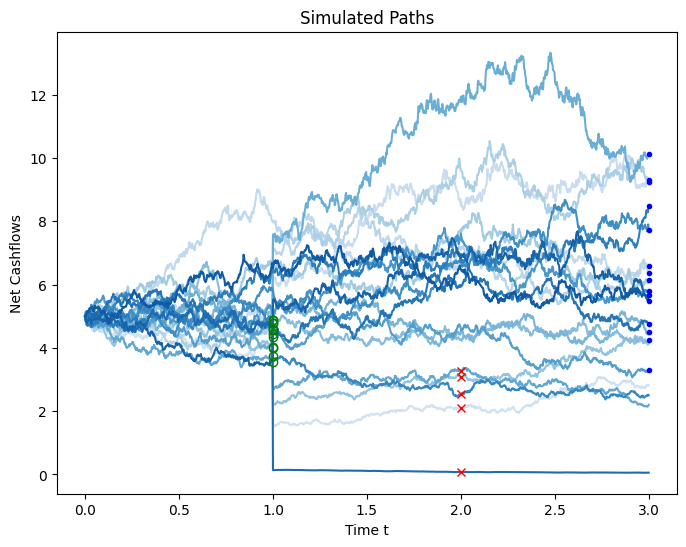

Payoff Process - trials: 25, drift: 0.02, vol: 0.2


In [3]:
# Simulation Parameters
N = 25        # no simulations
T = 3         # simulation periods
STEP = 365     # timesteps per period
TIME_ARRAY = np.linspace(0, T, STEP*T+1)
DRIFT = 0.02  # cashflow drift rate
VOL = 0.2     # cashflow volatility, look at 0 to 50
START = 3.0   # initial cashflow rate c0


# Create the project
project = LeanProjectValuation(cashflow_mu=DRIFT,
                               cashflow_sigma=VOL, 
                               cashflow_initial_vals=5.0, 
                               cost_initial_vals=10.0, 
                               risk_free_rate=0.05, 
                               rand_seed=1234, 
                               no_sims=20)
# simulate cashflows
unaltered_paths = project.generate_paths(TIME_ARRAY, 3)
ex_dec = project.exercise_decisions

## PLOTTING
# plot all cashflow and cost processes
plt.figure(figsize=FIGSIZE)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0.2, 1, N))))
plt.plot(TIME_ARRAY, project.unaltered_paths)

# pivots
for stage in [1]:
    pivots = [v for ex,v,_ in project.pivot_decisions[stage] if ex == 0]
    plt.plot(np.repeat([stage],len(pivots)), pivots, "go", markerfacecolor='none')
# abandoned paths
for stage in [2]:
    abandons = [v for p,ex,v,_ in project.exercise_decisions if ex == -1]
    plt.plot(np.repeat([stage],len(abandons)), abandons, "rx")
# completed projects
completions = project.paths[-1,:]
plt.plot(np.repeat([T],len(completions)), completions, "b.")

plt.title("Simulated Paths")
plt.xlabel("Time t")
plt.ylabel("Net Cashflows")
plt.show()
txt = f"""Payoff Process - trials: {N}, drift: {DRIFT}, vol: {VOL}"""
print(txt)

In [4]:
# Default Simulation Parameters
N = 10000      # no simulations
T = 3          # simulation periods
STEP = 365     # timesteps per period
TIME_ARRAY = np.linspace(0, T, STEP*T+1)
SEED = 1234

# Parameters
CF_INIT = 1.0
K = 2.0
CF_MU = 0.02
CF_SIGMA = 0.2
R = 0.05

In [5]:
def project_stats(pivot_dec, exercise_dec):
    pivots = [d for d,_,_ in pivot_dec[1]]
    exercises = [ d for _,d,_,_ in exercise_dec]

    abandons = [p for p,d in zip(pivots, exercises) if d == -1]
    completions = [p for p,d in zip(pivots, exercises) if d == 1] 

    abandon_pivots = float(abandons.count(1))/N
    abandon_nopivots = float(abandons.count(0))/N
    completion_pivots = float(completions.count(1))/N
    completion_nopivots = float(completions.count(0))/N

    # Create a dictionary to initialize the DataFrame
    data = {
        "pivot": [abandon_pivots, completion_pivots],
        "no-pivot": [abandon_nopivots, completion_nopivots]
    }
    # Create the DataFrame
    df = pd.DataFrame(data, index=["Abandons", "Completions"])
    # Add row sums
    df["% of Total"] = df.sum(axis=1)
    # Add column sums
    df.loc["% of Total"] = df.sum()
    return df

# Single Project
for sigma in [0.2, 0.4, 0.6, 0.8]:
    print(f"\nVolatility: {sigma}")
    proj = LeanProjectValuation(CF_MU, sigma, CF_INIT, K, R, rand_seed=SEED, no_sims=N)

    val_optimal = proj.valuation(TIME_ARRAY, 3)
    val_naive = proj.valuation(TIME_ARRAY, 3, unaltered=True)
    abandon_opt_val = val_optimal - val_naive
    print(f"Abandonment Option Value: {abandon_opt_val}")
    
    stats = project_stats(proj.pivot_decisions, proj.exercise_decisions)
    print(stats)

print(f"\nNo. simulations: {N}")



Volatility: 0.2
Abandonment Option Value: 0.19330873115452518
              pivot  no-pivot  % of Total
Abandons     0.0104    0.2155      0.2259
Completions  0.5042    0.2699      0.7741
% of Total   0.5146    0.4854      1.0000

Volatility: 0.4
Abandonment Option Value: 0.3151178205563161
              pivot  no-pivot  % of Total
Abandons     0.0518    0.3196      0.3714
Completions  0.4005    0.2281      0.6286
% of Total   0.4523    0.5477      1.0000

Volatility: 0.6
Abandonment Option Value: 0.481234029558281
              pivot  no-pivot  % of Total
Abandons     0.0843    0.4158      0.5001
Completions  0.3188    0.1811      0.4999
% of Total   0.4031    0.5969      1.0000

Volatility: 0.8
Abandonment Option Value: 0.6545564625128725
              pivot  no-pivot  % of Total
Abandons     0.1058    0.4966      0.6024
Completions  0.2564    0.1412      0.3976
% of Total   0.3622    0.6378      1.0000

No. simulations: 10000
